# Mixture Density Network

This notebook trains a simple gaussian mixture density network from basic statistics of the predictive distributions coming from the component models.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.data as udata
import utils.dists as udists
import utils.misc as u
import os
import losses

from functools import partial
from jrun import jin
from keras.layers import (Activation, Dense, Dropout, Embedding, Flatten, Merge, Reshape)
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.backend as K

Using Theano backend.


## Setup notebook parameters

In [51]:
EXP_NAME = jin("exp", "mdn/seasons-4-to-3")
COMPONENTS = jin("components", u.available_models("../data"))
WEEK_NUMBER = jin("week", 4)
TEST_SPLIT_THRESH = jin("splitweek", 201443)

## Load data

In [52]:
class Component:
    """
    Helper class for working with components
    """
    
    def __init__(self, name):
        self.name = name
        self.loader = udata.ComponentDataLoader("../data", name)

In [53]:
components = [Component(name) for name in COMPONENTS]
actual_dl = udata.ActualDataLoader("../data")

### Working on week ahead predictions

We need to take the common row entries (common "epiweek", "region") for each data item, i.e. actual data and component data.

In [54]:
REGION = None # Specify None for using all the data

y, Xs, yi = udata.get_week_ahead_training_data(
    WEEK_NUMBER, REGION,
    actual_dl, [cmp.loader for cmp in components]
)

for idx, cmp in enumerate(components):
    cmp.data = Xs[idx]

### Extracting statistical features from the distributions

We are just using the mean and std of distributions and concatenating to a single vector as input to the model.

*X* refers to combined features from all the models.

*X_[model]* refers to full distributions from a particular model.

In [55]:
X = udists.get_merged_features(
    Xs, 
    [udists.dist_mean, udists.dist_std]
)

### Split based on year
We take items before a certain epiweek as train and rest as test

In [56]:
train_indices = yi[:, 0] < TEST_SPLIT_THRESH

## Model

The model is a simple mixture density network which returns a set of parameters which are then used in the loss function to get the negative log score for optimization

In [57]:
def mdn(n_input, n_mix):
    """
    Return a mixture density model with given number of mixtures (gaussians)
    """
    
    model = Sequential()
    model.add(Dense(20, input_shape=(n_input,)))
    model.add(Activation("relu"))
    model.add(Dense(10))
    model.add(Activation("relu"))
    model.add(Dense(5))
    model.add(Activation("relu"))
    
    # Return 3 parameters, mu, sigma and mixture weight
    model.add(Dense(n_mix * 3))
    
    return model

In [58]:
N_MIX = 2
loss_fn = partial(losses.mdn_loss, n_mix=N_MIX)
loss_fn.__name__ = "mdn_loss" # Keras needs a name for function

### Training

In [59]:
# model generator
def gen_model():
    return mdn(X.shape[1], N_MIX)

def train_model(
    model, train_data, val_data,
    batch_size=64, epochs=100
):
    model.compile(optimizer="rmsprop", loss=loss_fn)

    if val_data is not None:
        callbacks = [EarlyStopping(monitor="val_loss", patience=4, mode="auto")]
    else:
        callbacks = []

    history = model.fit(train_data[0],
                        train_data[1],
                        batch_size=batch_size, epochs=epochs,
                        verbose=0,
                        callbacks=callbacks,
                        validation_data=val_data)
    return history

100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


,epochs,train_loss,val_loss
it-1,27.0,0.876128,0.958328
it-2,17.0,0.959511,0.838998
it-3,29.0,0.788872,1.411274
it-4,21.0,0.934785,1.185786
mean,23.5,0.889824,1.098597


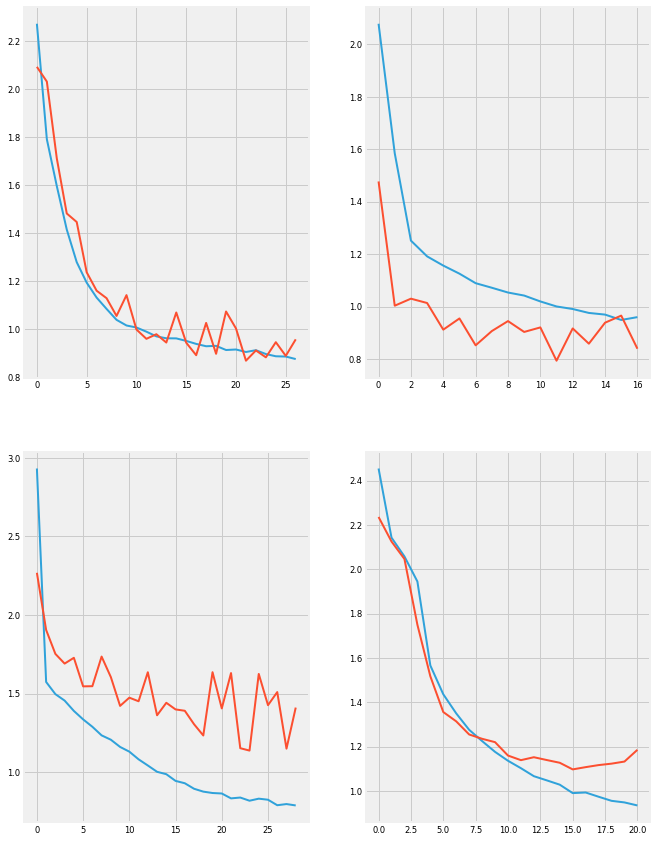

In [60]:
cv_metadata = u.cv_train_loso(
    gen_model, train_model,
    X[train_indices], y[train_indices], yi[train_indices]
)
u.cv_plot(cv_metadata)
cv_report = u.cv_report(cv_metadata)
cv_report

### Final model training

0.81109005688688451

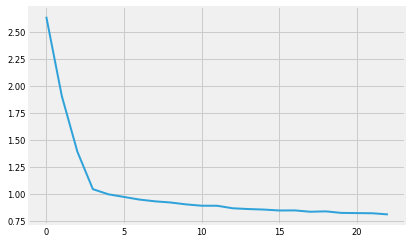

In [65]:
model = gen_model()
final_epochs = int(cv_report["epochs"][-1])
final_history = train_model(model, (X[train_indices], y[train_indices]), None, epochs=final_epochs)
final_loss = final_history.history["loss"][-1]
plt.plot(final_history.history["loss"])
final_loss

### Evaluation

In [66]:
regions = ["nat", *[f"hhs{i}" for i in range(1, 11)], None]

mdls = [*[cmp.name for cmp in components], "n-ensemble",
        "ave-ensemble", "prod-ensemble"]

eval_df = {mdl: [] for mdl in mdls}

for region in regions:
    if region is None:
        eval_indices = ~train_indices
    else:
        eval_indices = (~train_indices) & (yi[:, 1] == region)
        
    component_dists = [cmp.data[eval_indices] for cmp in components]
    n_dist = udists.mdn_params_to_dists(model.predict(X[eval_indices]))
    
    dists = [
        *component_dists,
        n_dist,
        udists.mean_ensemble(component_dists),
        udists.prod_ensemble(component_dists)
    ]
    y_one_hot = udists.wili_to_dists(y[eval_indices])
    
    for name, output in zip(mdls, dists):
        eval_df[name].append(losses.mean_cat_cross(y_one_hot, output))
eval_df = pd.DataFrame(eval_df)
eval_df.index = [*regions[:-1], "all"]
eval_df = eval_df[mdls]

# Save results
output_dir = u.ensure_dir(f"../results/{EXP_NAME}")
u.save_exp_summary(model, cv_report, {
    "loss": final_loss,
    "epochs": final_epochs
    
}, f"{output_dir}/{WEEK_NUMBER}_summary.txt")
eval_df.to_csv(f"{output_dir}/{WEEK_NUMBER}_eval.csv")
eval_df

,Delphi-DeltaDensity2,CU-BMA,CU-EAKFC,ReichLab-KDE,ReichLab-SARIMA1,Delphi-BasisRegression,Delphi-DeltaDensity1,Delphi-Uniform,ReichLab-SARIMA2,Delphi-Stat,Delphi-EmpiricalBayes1,Delphi-EmpiricalFuture,Delphi-EmpiricalBayes2,ReichLab-KCDE,Delphi-EmpiricalTraj,n-ensemble,ave-ensemble,prod-ensemble
nat,3.3640663792050054,3.912586991638724,3.7058545455684118,3.357279121390182,3.2631122329535978,4.612144719299143,3.050527305885287,4.900355404888464,3.2108823672974824,2.991344619815032,4.984483288117639,3.5765941011918265,5.828515185229669,3.0758660363893,3.5765941011918265,3.0860396504124994,3.1947406840957018,5.700987260706207
hhs1,3.1169786388926717,3.5623523383363453,3.2933664756488548,3.4552142106622132,3.284575648831529,4.63781303700519,3.017135546876288,5.011066366463577,3.0917526704635945,3.0174825996404704,4.109263242251136,3.439157047731076,5.1887966227434195,2.955526504139367,3.439157047731076,2.813561393225036,3.150409332578692,5.710815969625857
hhs2,4.352207729198658,4.643310020358598,5.144774877075257,4.033485863498903,3.8469505044419328,4.6157113539382895,4.259697214423117,4.860532328749034,3.8515090124446396,3.904740766387766,5.3586921944241235,4.005681980062041,6.555918416755372,3.8243475244686054,4.005681980062041,3.5622483680616543,3.8389332914862253,5.394522247189305
hhs3,3.6680733092068802,3.850689166464682,4.639429991600598,3.4747587518926175,3.620927931800722,4.625740404434962,3.334759243413396,4.911098959332391,3.6408625104805337,3.346303948544628,4.211797151901055,3.6958483321852715,5.831705189013642,3.49281814521405,3.6958483321852715,3.420401585639694,3.535394972477988,5.550609672532043
hhs4,3.979002453519353,3.9912281420212965,4.6051053164331295,3.7584017390665982,3.504230638498842,4.633699066950017,3.7186954950731868,4.92081380671395,3.4635147035374816,3.5844556205172418,6.458825489107449,3.9562591802125207,6.839322202361612,3.4852616060729664,3.9562591802125207,3.447573512652854,3.552470724264288,5.55848385365954
hhs5,3.445160666927539,4.199717416439037,3.7474659848179463,3.4211419216268606,3.350879727282929,4.639987376262257,3.0113278744998073,4.9667518667902675,3.2851421066167834,3.023364528792244,6.041452766493405,3.5150232658352354,6.301196730167281,3.240514651100157,3.5150232658352354,3.0163646129889505,3.267326364488474,5.634464305485387
hhs6,3.8649121873063756,5.15628669452761,5.7214918939290405,4.5236635910486385,4.327780381847414,4.624465388634123,3.86286792754456,4.802775952246232,4.193442167350084,3.8264217672672487,5.595805988744132,4.151772645412954,6.301136794171206,3.886918555804291,4.151772645412954,3.9465241191701956,4.033075385023065,5.288762318879266
hhs7,3.794537000290996,4.222620454755723,4.515032563470406,3.5275886177850757,3.614592678204976,4.6554889131964226,3.3094517493520277,4.986222841915924,3.466676914787228,3.334929023889551,5.355225948456844,3.631465618890114,6.243651069014943,3.4191999866616976,3.631465618890114,3.439838883477028,3.5340260001559267,5.5385939538988636
hhs8,2.994068767805269,3.420568984986876,3.331365493038697,3.314063994756497,3.2694561384694936,4.65075660879156,2.7434051090497795,5.0318629474239005,3.1993677980907824,2.770650569821222,3.441401901709687,3.2909419947999976,3.75164578001585,2.9715091970467986,3.2909419947999976,2.709647462513009,3.050934083298795,5.745060029675993
hhs9,3.3941612759199775,3.741167600367097,4.646124631882571,3.555464141919199,3.5853082748011866,4.610917998944085,3.16509562290047,4.888172511905588,3.4568436497158537,3.1653040152053866,3.8168302491477575,3.5654096965832993,5.610870536076787,3.26480067832295,3.5654096965832993,3.1014597861672675,3.37842803973167,5.574809974300193


## Plot random predictions

In [ ]:
# Sample few of the examples
n_plots = 5
plot_indices = np.random.randint(0, y[~train_indices].shape[0], size=n_plots)

y_plot_out = y[~train_indices][plot_indices]

component_dists = [cmp.data[~train_indices][plot_indices] for cmp in components]
n_dist = udists.mdn_params_to_dists(model.predict(X[~train_indices][plot_indices]))

dists = [
    *component_dists,
    n_dist,
    udists.mean_ensemble(component_dists),
    udists.prod_ensemble(component_dists)
]

bins = np.linspace(0, 12.9, 130)
mdls = [*[cmp.name for cmp in components], "n-ensemble", "ave-ensemble", "prod-ensemble"]

for pidx in range(n_plots):
    plt.figure(figsize=(14, 6))
    for idx, mdl in enumerate(mdls):
        plt.plot(bins, dists[idx][pidx], label=mdl)
    
    # Plot actual line
    plt.axvline(x=y_plot_out[pidx])
    
    plt.legend()